# カテゴリ値を含むデータでのLightGBMを使った分析

### データ
[Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) \
[Adult income dataset](https://www.kaggle.com/wenruliu/adult-income-dataset/version/2)

### 参考
[lightgbmで二値分類の一連の流れをしたメモ](https://qiita.com/d_desuyon/items/807e01311ad08570ee78) \
[【初心者向け】特徴量重要度の算出 (LightGBM) 【Python】【機械学習】](https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a)

In [1]:
!python -V

Python 3.8.8


In [2]:
!python -m pip --version

pip 21.3.1 from /opt/conda/lib/python3.8/site-packages/pip (python 3.8)


In [3]:
!python -m pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.0
anyio                         2.2.0
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
autopage                      0.5.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        3.3.0
blinker                       1.4
brotlipy                      0.7.0
category-encoders             2.3.0
certifi                       2020.12.5
certipy                       0.1.3
cffi                          1.14.5
chardet                       4.0.0
cliff                         3.10.0
cloudpickle                   2.0.0
cmaes                         0.8.2
cmd2                          2.3.3
colorlog                      6.6.0
conda                         4.10.0
conda-package-handling        1.7.3
cryptography                  3.4.7
cycler

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('adult.csv')

In [6]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
columns_cat = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country',
    #'income',
]

In [9]:
{cat:'category' for cat in columns_cat}

{'workclass': 'category',
 'education': 'category',
 'marital-status': 'category',
 'occupation': 'category',
 'relationship': 'category',
 'race': 'category',
 'gender': 'category',
 'native-country': 'category'}

In [10]:
df = df.astype({cat:'category' for cat in columns_cat})

In [11]:
for cat in columns_cat:
    print(cat, df[cat].cat.categories)

workclass Index(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
       'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
      dtype='object')
education Index(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype='object')
marital-status Index(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
       'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
      dtype='object')
occupation Index(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')
relationship Index(['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
       'Wife']

In [12]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [13]:
income_map = {'<=50K':0, '>50K':1}
df['income'] = df['income'].map(income_map).astype(int)

In [14]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,0
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 3.0 MB


In [16]:
#df['workclass'] = df['workclass'].replace('?',np.nan)
#df['occupation'] = df['occupation'].replace('?',np.nan)
#df['native-country'] = df['native-country'].replace('?',np.nan)
df = df.applymap(lambda d: np.nan if d=="?" else d)

In [17]:
df.isnull().sum(axis=0)

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [18]:
df = df.dropna(axis=0)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.5+ MB


In [20]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0
10,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,1
11,36,Federal-gov,212465,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,0


In [21]:
workclass = ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']
{v:i for i, v in enumerate(workclass)}

{'Federal-gov': 0,
 'Local-gov': 1,
 'Never-worked': 2,
 'Private': 3,
 'Self-emp-inc': 4,
 'Self-emp-not-inc': 5,
 'State-gov': 6,
 'Without-pay': 7}

In [22]:
df['workclass'] = df['workclass'].map({v:i for i, v in enumerate(workclass)}).astype(int)

In [23]:
occupation = ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving']
{v:i for i, v in enumerate(occupation)}

{'Adm-clerical': 0,
 'Armed-Forces': 1,
 'Craft-repair': 2,
 'Exec-managerial': 3,
 'Farming-fishing': 4,
 'Handlers-cleaners': 5,
 'Machine-op-inspct': 6,
 'Other-service': 7,
 'Priv-house-serv': 8,
 'Prof-specialty': 9,
 'Protective-serv': 10,
 'Sales': 11,
 'Tech-support': 12,
 'Transport-moving': 13}

In [24]:
df['occupation'] = df['occupation'].map({v:i for i, v in enumerate(occupation)}).astype(int)

In [25]:
nativecountry = ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba',
       'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France',
       'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands',
       'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy',
       'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua',
       'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
       'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']
{v:i for i, v in enumerate(nativecountry)}

{'Cambodia': 0,
 'Canada': 1,
 'China': 2,
 'Columbia': 3,
 'Cuba': 4,
 'Dominican-Republic': 5,
 'Ecuador': 6,
 'El-Salvador': 7,
 'England': 8,
 'France': 9,
 'Germany': 10,
 'Greece': 11,
 'Guatemala': 12,
 'Haiti': 13,
 'Holand-Netherlands': 14,
 'Honduras': 15,
 'Hong': 16,
 'Hungary': 17,
 'India': 18,
 'Iran': 19,
 'Ireland': 20,
 'Italy': 21,
 'Jamaica': 22,
 'Japan': 23,
 'Laos': 24,
 'Mexico': 25,
 'Nicaragua': 26,
 'Outlying-US(Guam-USVI-etc)': 27,
 'Peru': 28,
 'Philippines': 29,
 'Poland': 30,
 'Portugal': 31,
 'Puerto-Rico': 32,
 'Scotland': 33,
 'South': 34,
 'Taiwan': 35,
 'Thailand': 36,
 'Trinadad&Tobago': 37,
 'United-States': 38,
 'Vietnam': 39,
 'Yugoslavia': 40}

In [26]:
df['native-country'] = df['native-country'].map({v:i for i, v in enumerate(nativecountry)}).astype(int)

In [27]:
education = ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college']
{v:i for i, v in enumerate(education)}

{'10th': 0,
 '11th': 1,
 '12th': 2,
 '1st-4th': 3,
 '5th-6th': 4,
 '7th-8th': 5,
 '9th': 6,
 'Assoc-acdm': 7,
 'Assoc-voc': 8,
 'Bachelors': 9,
 'Doctorate': 10,
 'HS-grad': 11,
 'Masters': 12,
 'Preschool': 13,
 'Prof-school': 14,
 'Some-college': 15}

In [28]:
df['education'] = df['education'].map({v:i for i, v in enumerate(education)}).astype(int)

In [29]:
maritalstatus = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
       'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']
{v:i for i, v in enumerate(maritalstatus)}

{'Divorced': 0,
 'Married-AF-spouse': 1,
 'Married-civ-spouse': 2,
 'Married-spouse-absent': 3,
 'Never-married': 4,
 'Separated': 5,
 'Widowed': 6}

In [30]:
df['marital-status'] = df['marital-status'].map({v:i for i, v in enumerate(maritalstatus)}).astype(int)

In [31]:
relationship = ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']
{v:i for i, v in enumerate(relationship)}

{'Husband': 0,
 'Not-in-family': 1,
 'Other-relative': 2,
 'Own-child': 3,
 'Unmarried': 4,
 'Wife': 5}

In [32]:
df['relationship'] = df['relationship'].map({v:i for i, v in enumerate(relationship)}).astype(int)

In [33]:
race = ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
{v:i for i, v in enumerate(race)}

{'Amer-Indian-Eskimo': 0,
 'Asian-Pac-Islander': 1,
 'Black': 2,
 'Other': 3,
 'White': 4}

In [34]:
df['race'] = df['race'].map({v:i for i, v in enumerate(race)}).astype(int)

In [35]:
gender = ['Female', 'Male']
{v:i for i, v in enumerate(gender)}

{'Female': 0, 'Male': 1}

In [36]:
df['gender'] = df['gender'].map({v:i for i, v in enumerate(gender)}).astype(int)

In [37]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,38,1
5,34,3,198693,0,6,4,7,1,4,1,0,0,30,38,0
7,63,5,104626,14,15,2,9,0,4,1,3103,0,32,38,1
8,24,3,369667,15,10,4,7,4,4,0,0,0,40,38,0
9,55,3,104996,5,4,2,2,0,4,1,0,0,10,38,0
10,65,3,184454,11,9,2,6,0,4,1,6418,0,40,38,1
11,36,0,212465,9,13,2,0,0,4,1,0,0,40,38,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              45222 non-null  int64
 1   workclass        45222 non-null  int64
 2   fnlwgt           45222 non-null  int64
 3   education        45222 non-null  int64
 4   educational-num  45222 non-null  int64
 5   marital-status   45222 non-null  int64
 6   occupation       45222 non-null  int64
 7   relationship     45222 non-null  int64
 8   race             45222 non-null  int64
 9   gender           45222 non-null  int64
 10  capital-gain     45222 non-null  int64
 11  capital-loss     45222 non-null  int64
 12  hours-per-week   45222 non-null  int64
 13  native-country   45222 non-null  int64
 14  income           45222 non-null  int64
dtypes: int64(15)
memory usage: 5.5 MB


In [39]:
import csv
df.to_csv('adult_cat2num.csv', index=False, header=True, encoding='UTF-8', sep=',', quoting=csv.QUOTE_ALL)

In [40]:
# 不要カラムの削除と並べ替え
df = df[["age",
         "workclass",
         #"fnlwgt",
         "education",
         "educational-num",
         "marital-status",
         "occupation",
         "relationship",
         "race",
         "gender",
         "capital-gain",
         "capital-loss",
         "hours-per-week",
         "native-country",
         "income",]]
df.head(10)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,15,10,2,6,0,2,1,7688,0,40,38,1
5,34,3,0,6,4,7,1,4,1,0,0,30,38,0
7,63,5,14,15,2,9,0,4,1,3103,0,32,38,1
8,24,3,15,10,4,7,4,4,0,0,0,40,38,0
9,55,3,5,4,2,2,0,4,1,0,0,10,38,0
10,65,3,11,9,2,6,0,4,1,6418,0,40,38,1
11,36,0,9,13,2,0,0,4,1,0,0,40,38,0


In [41]:
X = df.drop(['income'], axis=1)
y = df['income']

#Creation of Train and Test dataset
X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.2, shuffle=False)

#Creation of Train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [42]:
print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_valid.shape, y_valid.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (28941, 13)(28941,)
Validation dataset: (7236, 13)(7236,)
Test dataset: (9045, 13)(9045,)


In [43]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [44]:
# LightGBM のハイパーパラメータ
params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    'metric': 'auc',
    # Fatal の場合出力
    'verbosity': -1,
    # 乱数シード
    'seed': 31,
    # 学習率
    'learning_rate': 0.02,
}

In [45]:
# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train, valid_sets=lgb_valid,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=10000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.913581
[100]	valid_0's auc: 0.918224
[150]	valid_0's auc: 0.922523
[200]	valid_0's auc: 0.925081
[250]	valid_0's auc: 0.926737
[300]	valid_0's auc: 0.927531
[350]	valid_0's auc: 0.928011
[400]	valid_0's auc: 0.928321
[450]	valid_0's auc: 0.928423
[500]	valid_0's auc: 0.928465
[550]	valid_0's auc: 0.928541
[600]	valid_0's auc: 0.928542
[650]	valid_0's auc: 0.928369
Early stopping, best iteration is:
[584]	valid_0's auc: 0.928584


In [46]:
# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

AUC 0.9304952602676169


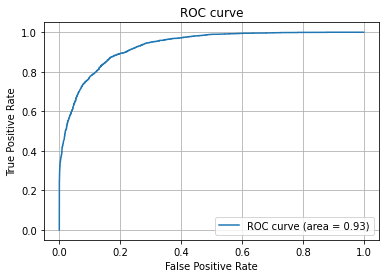

accuracy 0.8744057490326147
precision 0.8043818466353677


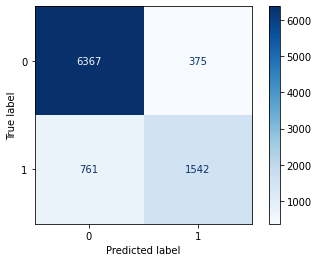

In [47]:
# AUCを計算
fpr, tpr, thresholds = roc_curve(np.asarray(y_test), y_pred)
print("AUC", auc(fpr, tpr))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc(fpr, tpr))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# accuracy, precisionを計算
acc = accuracy_score(np.asarray(y_test), np.round(y_pred))
precision = precision_score(np.asarray(y_test), np.round(y_pred))
print("accuracy", acc)
print("precision", precision)

# 混同行列をプロット
y_pred = np.round(y_pred)
cm = confusion_matrix(np.asarray(y_test), np.where(y_pred < 0.5, 0, 1))
cmp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmp.plot(cmap=plt.cm.Blues)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

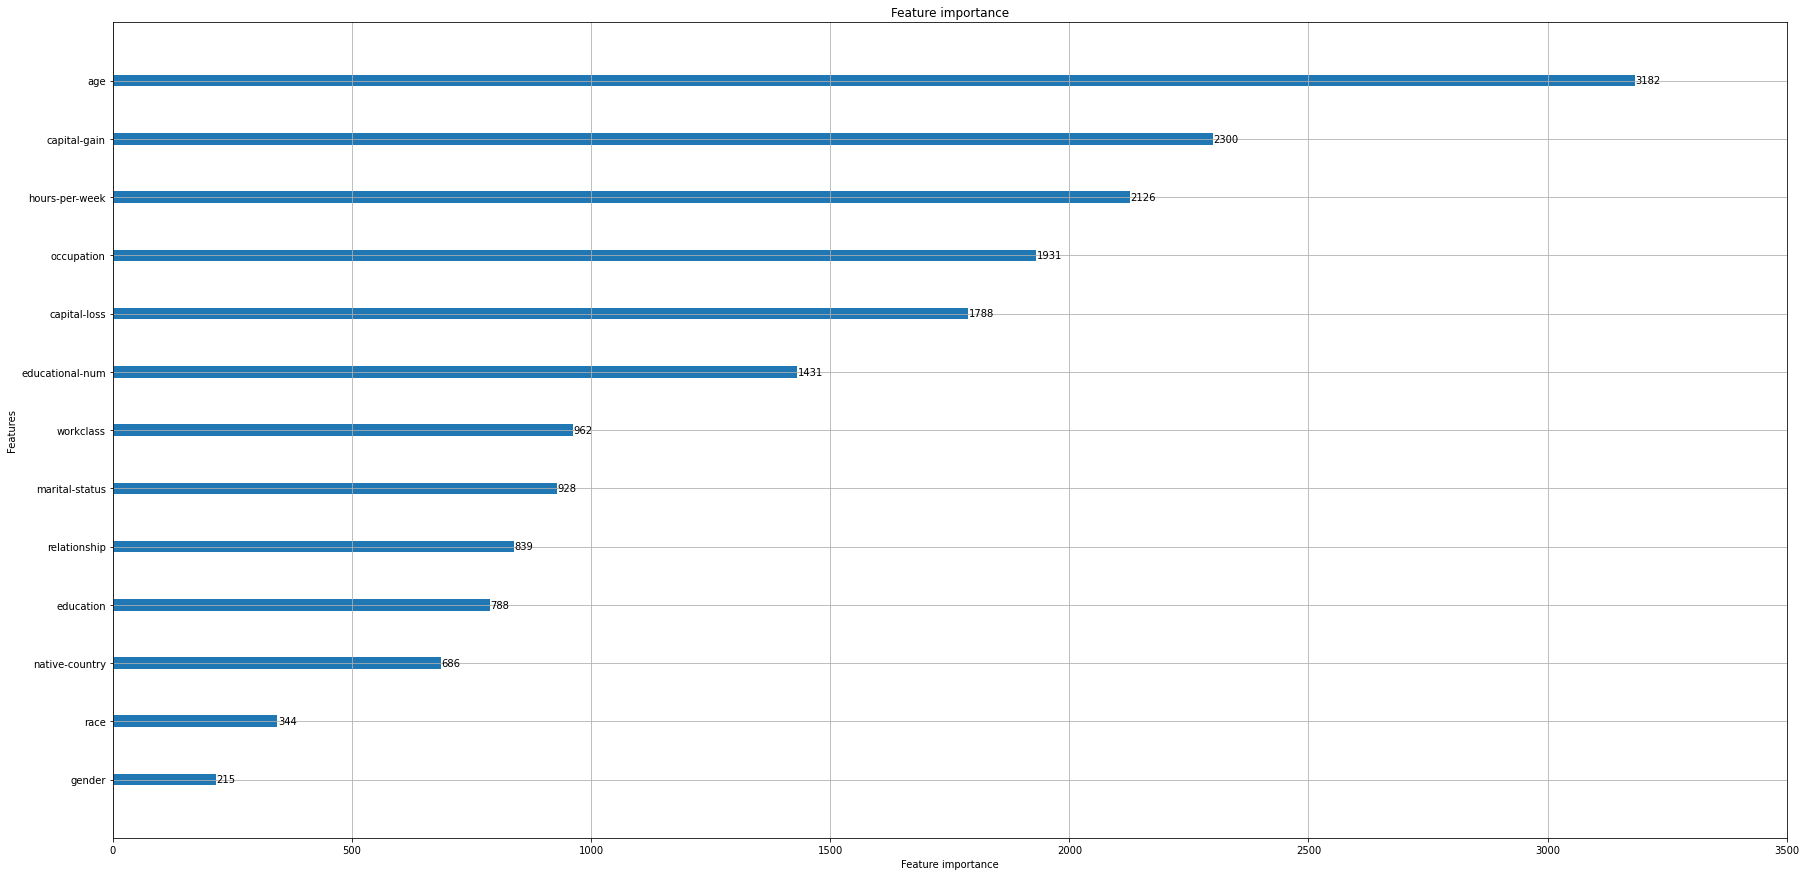

In [48]:
# 重要度としては「特徴量が分岐（ノード）の条件式で使用された回数」（＝デフォルト）
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

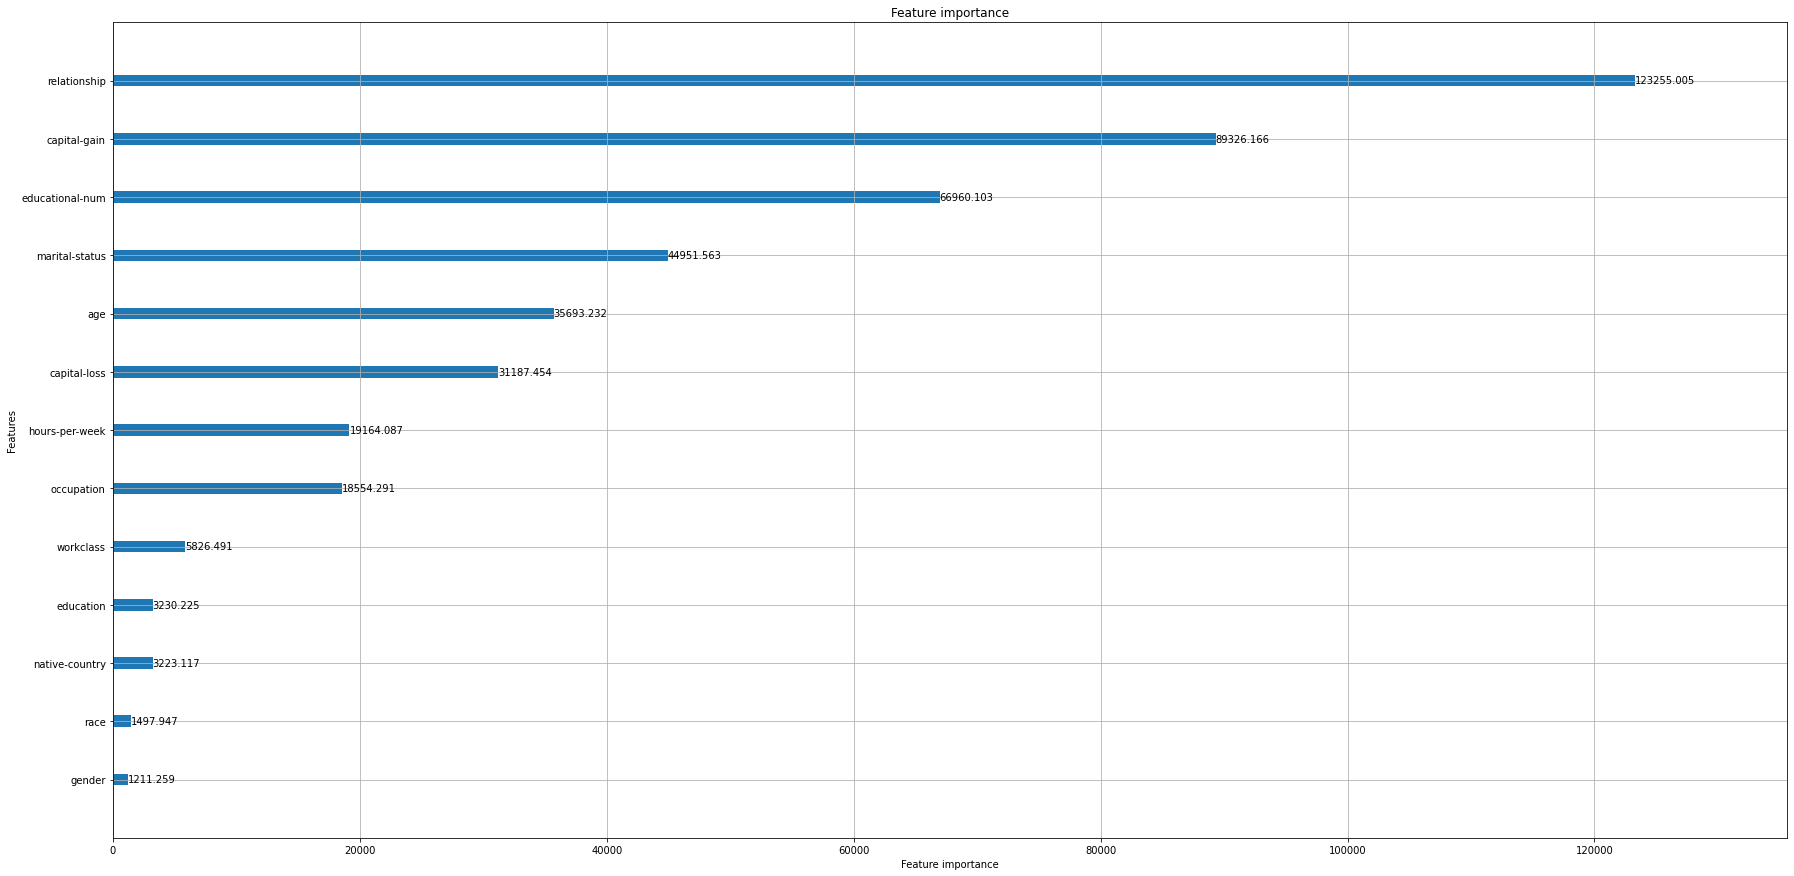

In [49]:
# 重要度としては「特徴量がある分岐（ノード）において目的関数の改善に寄与した度合い」
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='gain')

In [50]:
# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [51]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [52]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(df.drop('income',axis=1).columns) # 特徴量名のリスト(目的変数target以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
6,relationship,0.277551
9,capital-gain,0.201148
3,educational-num,0.150784
4,marital-status,0.101224
0,age,0.080376


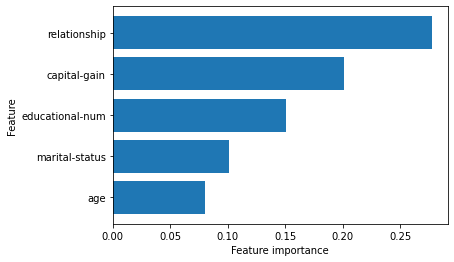

In [53]:
# 特徴量重要度の可視化
n_display = 5 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])